# Import Libraries

In [1]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install matplotlib 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json

import warnings
warnings.filterwarnings('ignore')

# Constants

In [8]:
TARGET_COLUMN = "indeks_pembangunan_manusia"

# Helper Functions

## Visualize Distribution

In [9]:
def visualize_distribution(df, target_column=TARGET_COLUMN):
  col_count = df.shape[1] - 2
  plot_index = 1
  plt.figure(figsize=(20, 5 * col_count))

  for col in df.columns[2:]:
    color = "orange" if col == target_column else "skyblue"
    
    # Histogram
    ax1 = plt.subplot(col_count, 3, plot_index)
    sns.histplot(df[col], bins=30, kde=False, ax=ax1, color=color)
    ax1.annotate(f'skewness: {df[col].skew():.2f}\nkurtosis: {df[col].kurtosis():.2f}\nstd: {df[col].std():.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=10, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.5))
    ax1.set_title(f'Distribusi {col}')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Frekuensi')
    ax1.grid(True, alpha=0.3)

    # Boxplot
    ax2 = plt.subplot(col_count, 3, plot_index + 1)
    sns.boxplot(x=df[col], ax=ax2, color=color)
    ax2.set_title(f'Boxplot {col}')
    ax2.grid(True, alpha=0.3)
    
    # Scatter plot vs Target
    ax3 = plt.subplot(col_count, 3, plot_index + 2)
    sns.scatterplot(x=df[col], y=df[target_column], ax=ax3, color=color)
    sns.regplot(x=df[col], y=df[target_column], scatter=False, ax=ax3, color='red', line_kws={"linewidth":1})
    corr, p_value = stats.pearsonr(df[col], df[target_column])
    ax3.annotate(f'Corr: {corr:.2f}\nP-value: {p_value:.2e}', xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=10, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.5))
    ax3.set_title(f'Scatter Plot {col} vs {target_column}')
    ax3.grid(True, alpha=0.3)
    plot_index += 3

  plt.tight_layout()
  plt.show()

## Visualize Classical Assumptions

In [10]:
def visualize_classical_assumptions(model):
  fitted_vals = model.fittedvalues
  residuals = model.resid
  lowess_curve = lowess(residuals, fitted_vals, frac=0.3)
  standardized_residuals = residuals / np.std(residuals)
  sqrt_std_resid = np.sqrt(np.abs(standardized_residuals))
  lowess_curve_sl = lowess(sqrt_std_resid, fitted_vals, frac=0.3)
  influence = model.get_influence()
  leverage = influence.hat_matrix_diag
  standardized_residuals = influence.resid_studentized_internal
  cooks_d = influence.cooks_distance[0]
  
  plt.figure(figsize=(20, 15))
  plot_num = 1
  
  # Residuals vs Fitted
  ax1 = plt.subplot(3, 3, plot_num)
  sns.scatterplot(x=fitted_vals, y=residuals, color='blue', alpha=0.3)
  ax1.axhline(0, color='green', linestyle='--')
  ax1.plot(lowess_curve[:, 0], lowess_curve[:, 1], color='red', linewidth=2, label='LOWESS Curve')
  ax1.set_title('Residuals vs Fitted Values\n(Ideal: Points follow red line)')
  ax1.set_xlabel('Fitted Values')
  ax1.set_ylabel('Residuals')
  ax1.grid(True, alpha=0.3)
  plot_num += 1

  # Q-Q Plot
  ax2 = plt.subplot(3, 3, plot_num)
  sm.qqplot(residuals, line='45', fit=True, ax=ax2)
  ax2.set_title('Q-Q Plot of Residuals\n(Ideal: Points follow 45-degree line)')
  ax2.grid(True, alpha=0.3)
  plot_num += 1

  # Scale-Location Plot
  ax3 = plt.subplot(3, 3, plot_num)
  sns.scatterplot(x=fitted_vals, y=sqrt_std_resid, color='blue', alpha=0.3)
  ax3.plot(lowess_curve_sl[:, 0], lowess_curve_sl[:, 1], color='red', linewidth=2, label='LOWESS Curve')
  ax3.set_title('Scale-Location Plot\n(Ideal: Horizontal red line with equally spread points)')
  ax3.set_xlabel('Fitted Values')
  ax3.set_ylabel('$\sqrt{|\\text{Standardized Residuals}|}$')
  ax3.grid(True, alpha=0.3)
  plot_num += 1

  # Residuals Histogram
  ax4 = plt.subplot(3, 3, plot_num)
  sns.histplot(residuals, bins=30, kde=True, color='blue', stat='density')
  xmin, xmax = plt.xlim()
  x_vals = np.linspace(xmin, xmax, 100)
  p = stats.norm.pdf(x_vals, residuals.mean(), residuals.std())
  ax4.plot(x_vals, p, 'r', linewidth=2, alpha=0.5)
  ax4.set_title('Histogram of Residuals with Normal Curve')
  ax4.set_xlabel('Residuals')
  ax4.set_ylabel('Density')
  ax4.grid(True, alpha=0.3)
  plot_num += 1
  
  # Residuals vs Leverage
  ax5 = plt.subplot(3, 3, plot_num)
  sns.scatterplot(x=leverage, y=standardized_residuals, color='blue', alpha=0.3)
  ax5.axhline(0, color='green', linestyle='--')
  ax5.set_title('Residuals vs Leverage\n(Ideal: No patterns, points within bounds)')
  ax5.axhline(3, color='red', linestyle='--', label='Thresholds')
  ax5.axhline(-3, color='red', linestyle='--')
  ax5.set_xlabel('Leverage')
  ax5.set_ylabel('Standardized Residuals')
  ax5.grid(True, alpha=0.3)
  plot_num += 1

  # Cooks Distance
  ax6 = plt.subplot(3, 3, plot_num)
  sns.scatterplot(x=np.arange(len(cooks_d)), y=cooks_d, color='blue', alpha=0.3)
  ax6.set_title("Cook's Distance for Each Observation")
  ax6.set_xlabel('Observation Index')
  ax6.set_ylabel("Cook's Distance")
  ax6.axhline(4 / len(cooks_d), color='red', linestyle='--', label='Threshold (4/n)')
  ax6.legend
  ax6.grid(True, alpha=0.3)
  plot_num += 1
  
  # Autocorrelation of Residuals
  ax7 = plt.subplot(3, 3, plot_num)
  sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax7)
  ax7.set_title('Autocorrelation of Residuals')
  ax7.grid(True, alpha=0.3)
  
  plt.tight_layout()
  plt.show()

# Data Acquisition

In [11]:
df = pd.read_csv("./Processed Data/processed_data.csv")

In [12]:
print("5 Data Pertama:")
display(df.head())

print("\nInformasi Dataset:")
print(df.info())

print("\nStatistik Deskriptif:")
display(df.describe())

print(f"\nRentang Tahun: {df['tahun'].min()} - {df['tahun'].max()}")
print(f"Jumlah Kabupaten/Kota: {df['kabupaten'].nunique()}")

5 Data Pertama:


,kabupaten,tahun,indeks_kemahalan_konstruksi,indeks_pembangunan_manusia,produk_domestik_regional_bruto,persentase_penduduk_miskin,prevalensi_ketidakcukupan_konsumsi_pangan,proporsi_perempuan_melahirkan_anak_pertama_kurang_dari_20_tahun
0,Simeulue,2020,109.99,66.03,2274.36,18.49,11.44,0.291
1,Aceh Singkil,2020,99.72,68.94,2422.61,20.20,7.19,0.283
2,Aceh Selatan,2020,98.07,67.12,5530.75,12.87,8.57,0.287
3,Aceh Tenggara,2020,100.77,69.37,5058.53,13.21,9.42,0.264
4,Aceh Timur,2020,95.43,67.63,10605.78,14.08,7.03,0.268



Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1542 entries, 0 to 1541
Data columns (total 8 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   kabupaten                                                        1542 non-null   object 
 1   tahun                                                            1542 non-null   int64  
 2   indeks_kemahalan_konstruksi                                      1542 non-null   float64
 3   indeks_pembangunan_manusia                                       1542 non-null   float64
 4   produk_domestik_regional_bruto                                   1542 non-null   float64
 5   persentase_penduduk_miskin                                       1542 non-null   float64
 6   prevalensi_ketidakcukupan_konsumsi_pangan                        1542 non-null   float64
 7   proporsi_perempuan_mela

,tahun,indeks_kemahalan_konstruksi,indeks_pembangunan_manusia,produk_domestik_regional_bruto,persentase_penduduk_miskin,prevalensi_ketidakcukupan_konsumsi_pangan,proporsi_perempuan_melahirkan_anak_pertama_kurang_dari_20_tahun
count,1542.000000,1542.000000,1542.000000,1542.000000,1542.000000,1542.000000,1542.000000
mean,2021.000000,108.356712,70.049092,33803.666686,11.963268,12.443690,0.268211
std,0.816761,39.160539,6.487585,74598.487828,7.386939,10.084746,0.096088
min,2020.000000,80.040000,31.550000,226.970000,2.020000,0.830000,0.037000
25%,2020.000000,95.250000,66.882500,5774.400000,6.832500,6.540000,0.195000
50%,2021.000000,100.700000,69.755000,13426.295000,10.125000,9.745000,0.272000
75%,2022.000000,107.275000,73.270000,30891.040000,14.572500,14.207500,0.341750
max,2022.000000,492.620000,87.690000,795394.800000,42.030000,80.320000,0.540000



Rentang Tahun: 2020 - 2022
Jumlah Kabupaten/Kota: 514


# Train-Test Split

Memisah data dengan spesifikasi:
- tahun 2020-2021 sebagai **training set**
- tahun 2022 sebagai **test set**

In [13]:
train_df = df[df['tahun'] < 2022]
test_df = df[df['tahun'] == 2022]

# EDA (Sebelum Transformasi)

## Distribusi Tiap Variabel

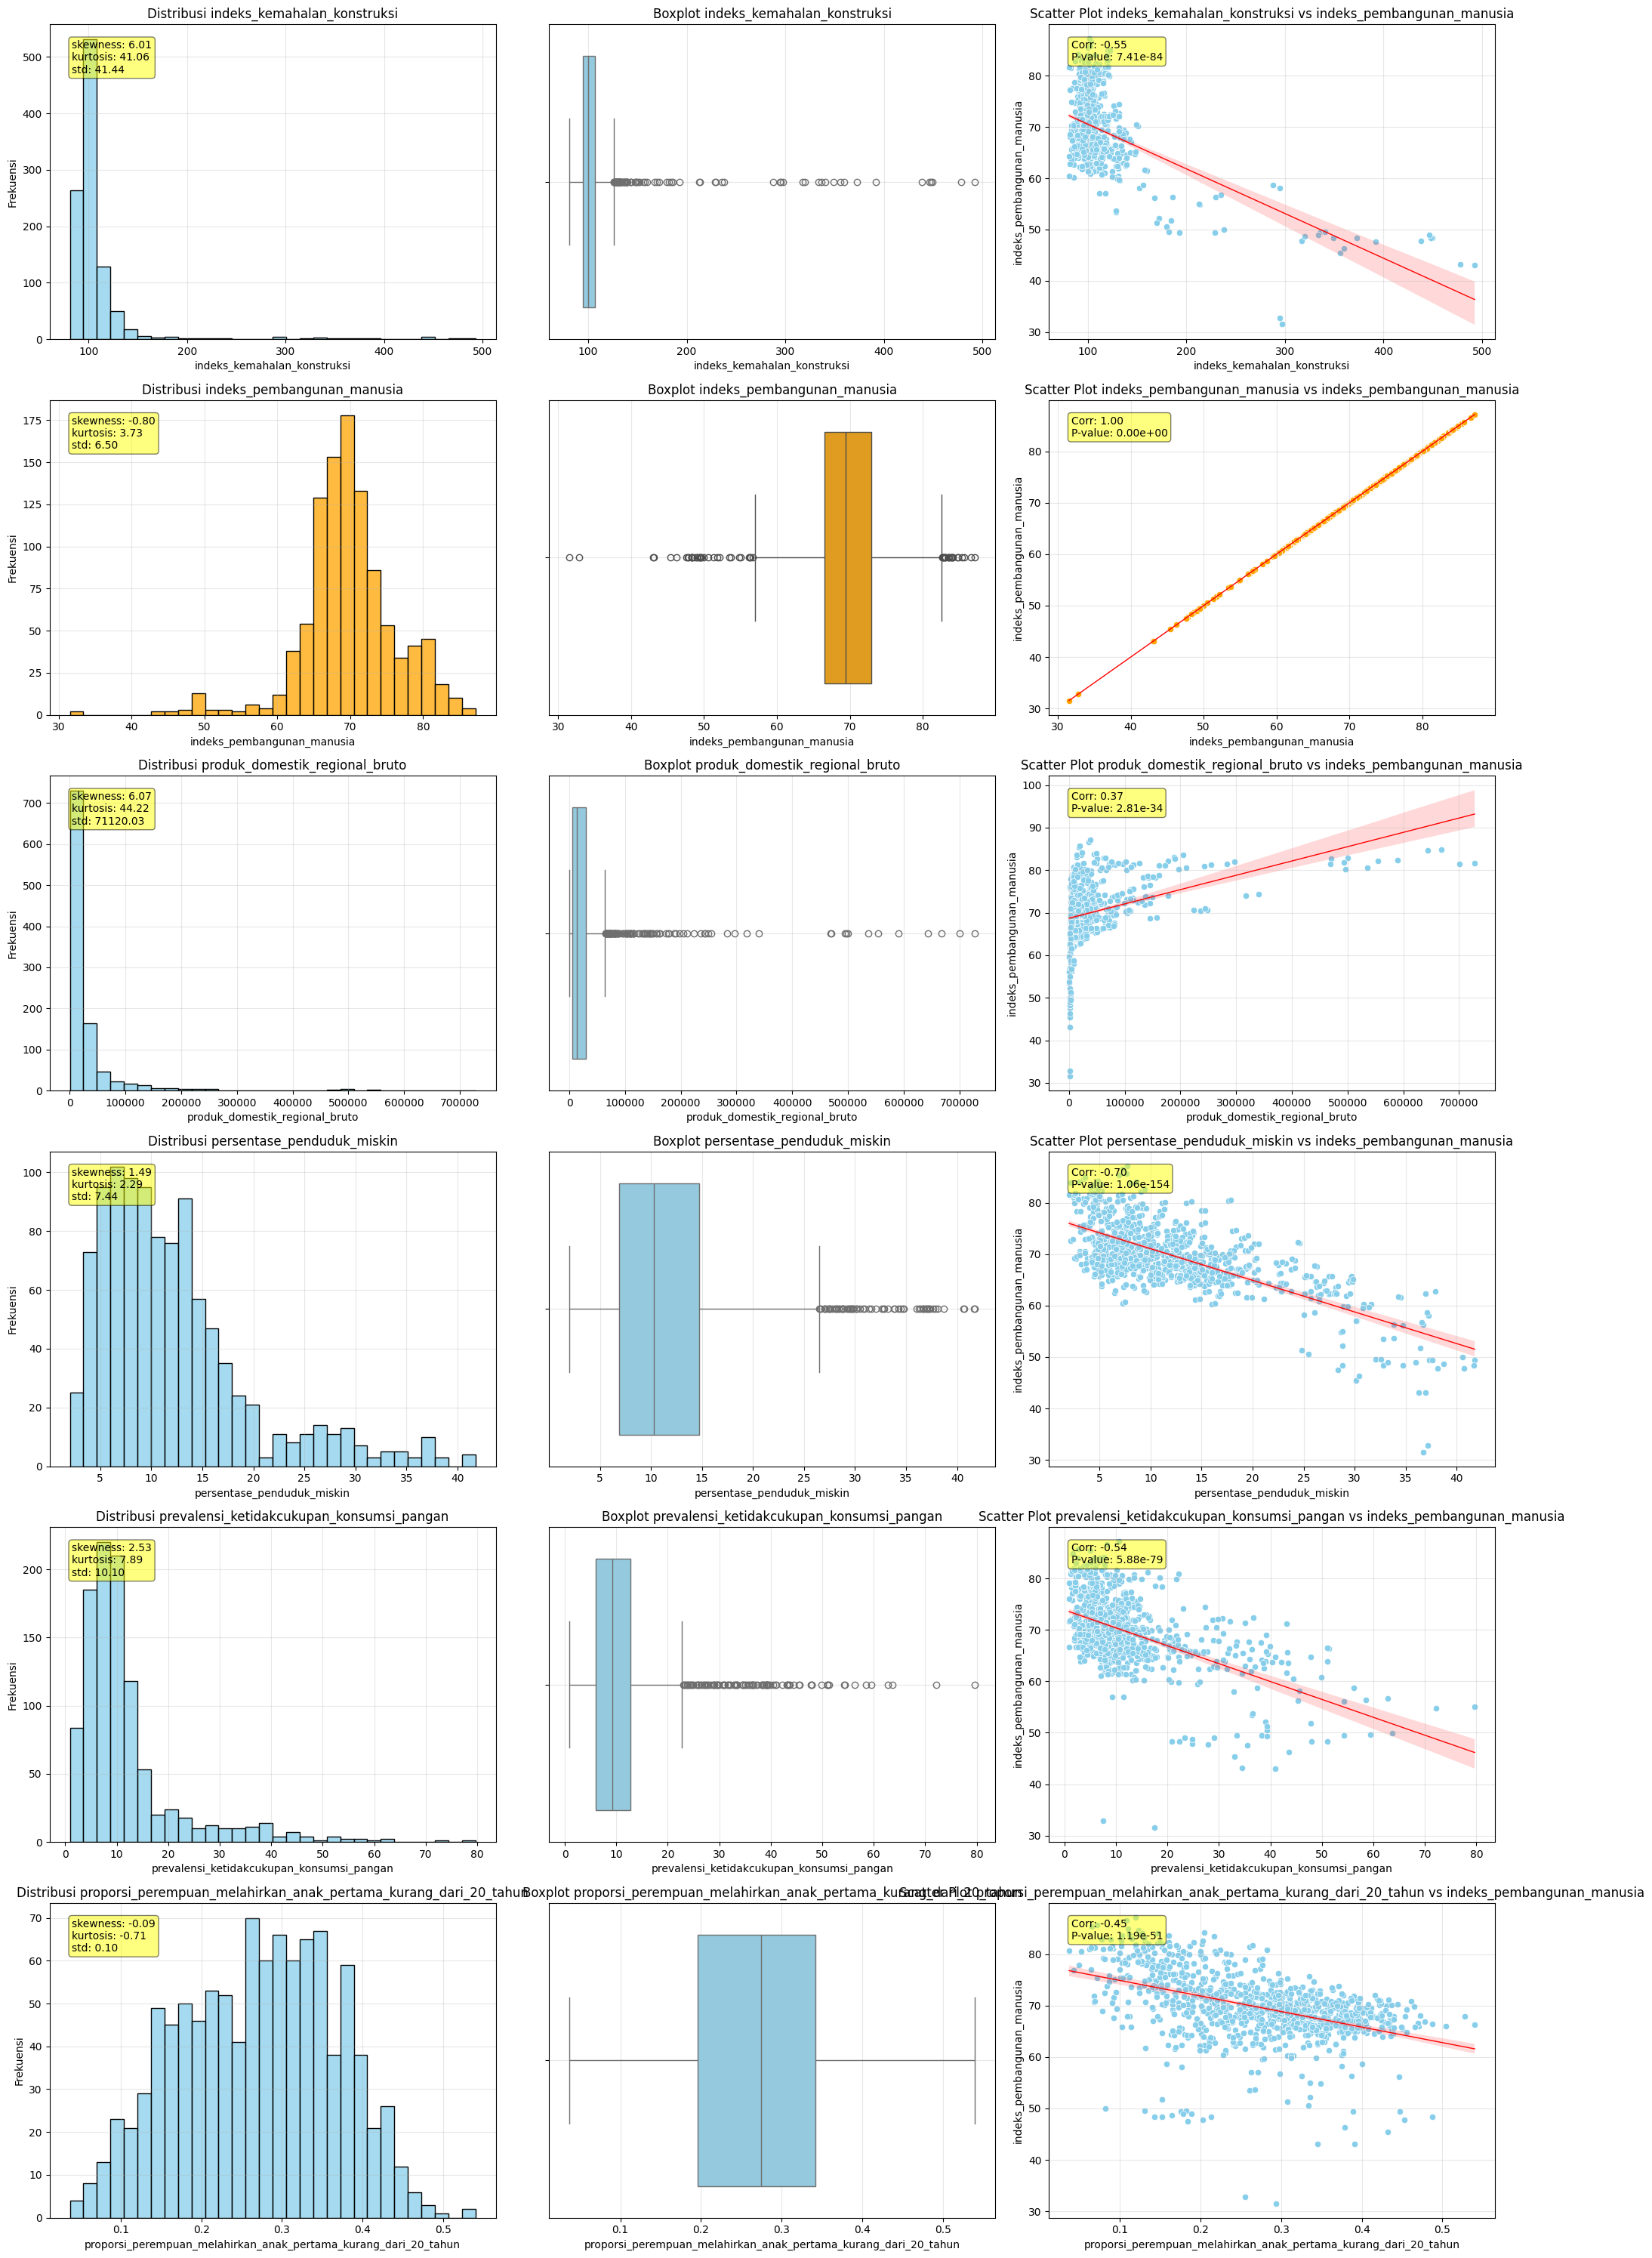

In [14]:
visualize_distribution(train_df, target_column=TARGET_COLUMN)

## Variance Influence Factor (VIF)

In [15]:
variables = train_df.columns[2:].tolist()
variables.remove(TARGET_COLUMN)

X = test_df[variables]

# Add constant untuk regression
X_const = add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = variables
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(variables))]

vif_data

,Variable,VIF
0,indeks_kemahalan_konstruksi,1.561291
1,produk_domestik_regional_bruto,1.128951
2,persentase_penduduk_miskin,1.799703
3,prevalensi_ketidakcukupan_konsumsi_pangan,1.575810
4,proporsi_perempuan_melahirkan_anak_pertama_kur...,1.057384


# Linear Regression (OLS) Sebelum Transformasi

## Pemodelan

In [16]:
X = train_df.drop(columns=["kabupaten", "tahun", TARGET_COLUMN])
y = train_df[TARGET_COLUMN]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit(cov_type='HC3')

In [17]:
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     indeks_pembangunan_manusia   R-squared:                       0.720
Model:                                    OLS   Adj. R-squared:                  0.719
Method:                         Least Squares   F-statistic:                     340.5
Date:                        Sat, 06 Dec 2025   Prob (F-statistic):          1.08e-214
Time:                                18:44:47   Log-Likelihood:                -2728.1
No. Observations:                        1028   AIC:                             5468.
Df Residuals:                            1022   BIC:                             5498.
Df Model:                                   5                                         
Covariance Type:                          HC3                                         
                                                                      coef    std err          z      P>|z|      [0.025      0.975

## Uji Asumsi Klasik

In [18]:
reset_result = linear_reset(model, power=2, use_f=True)
bp_test = het_breuschpagan(model.resid, model.model.exog)

print(reset_result)
print(bp_test)

<F test: F=18.87240047993174, p=1.5370965180955955e-05, df_denom=1.02e+03, df_num=1>
(np.float64(77.34108754147174), np.float64(3.018317330101287e-15), np.float64(16.629011821489087), np.float64(8.182912120522057e-16))


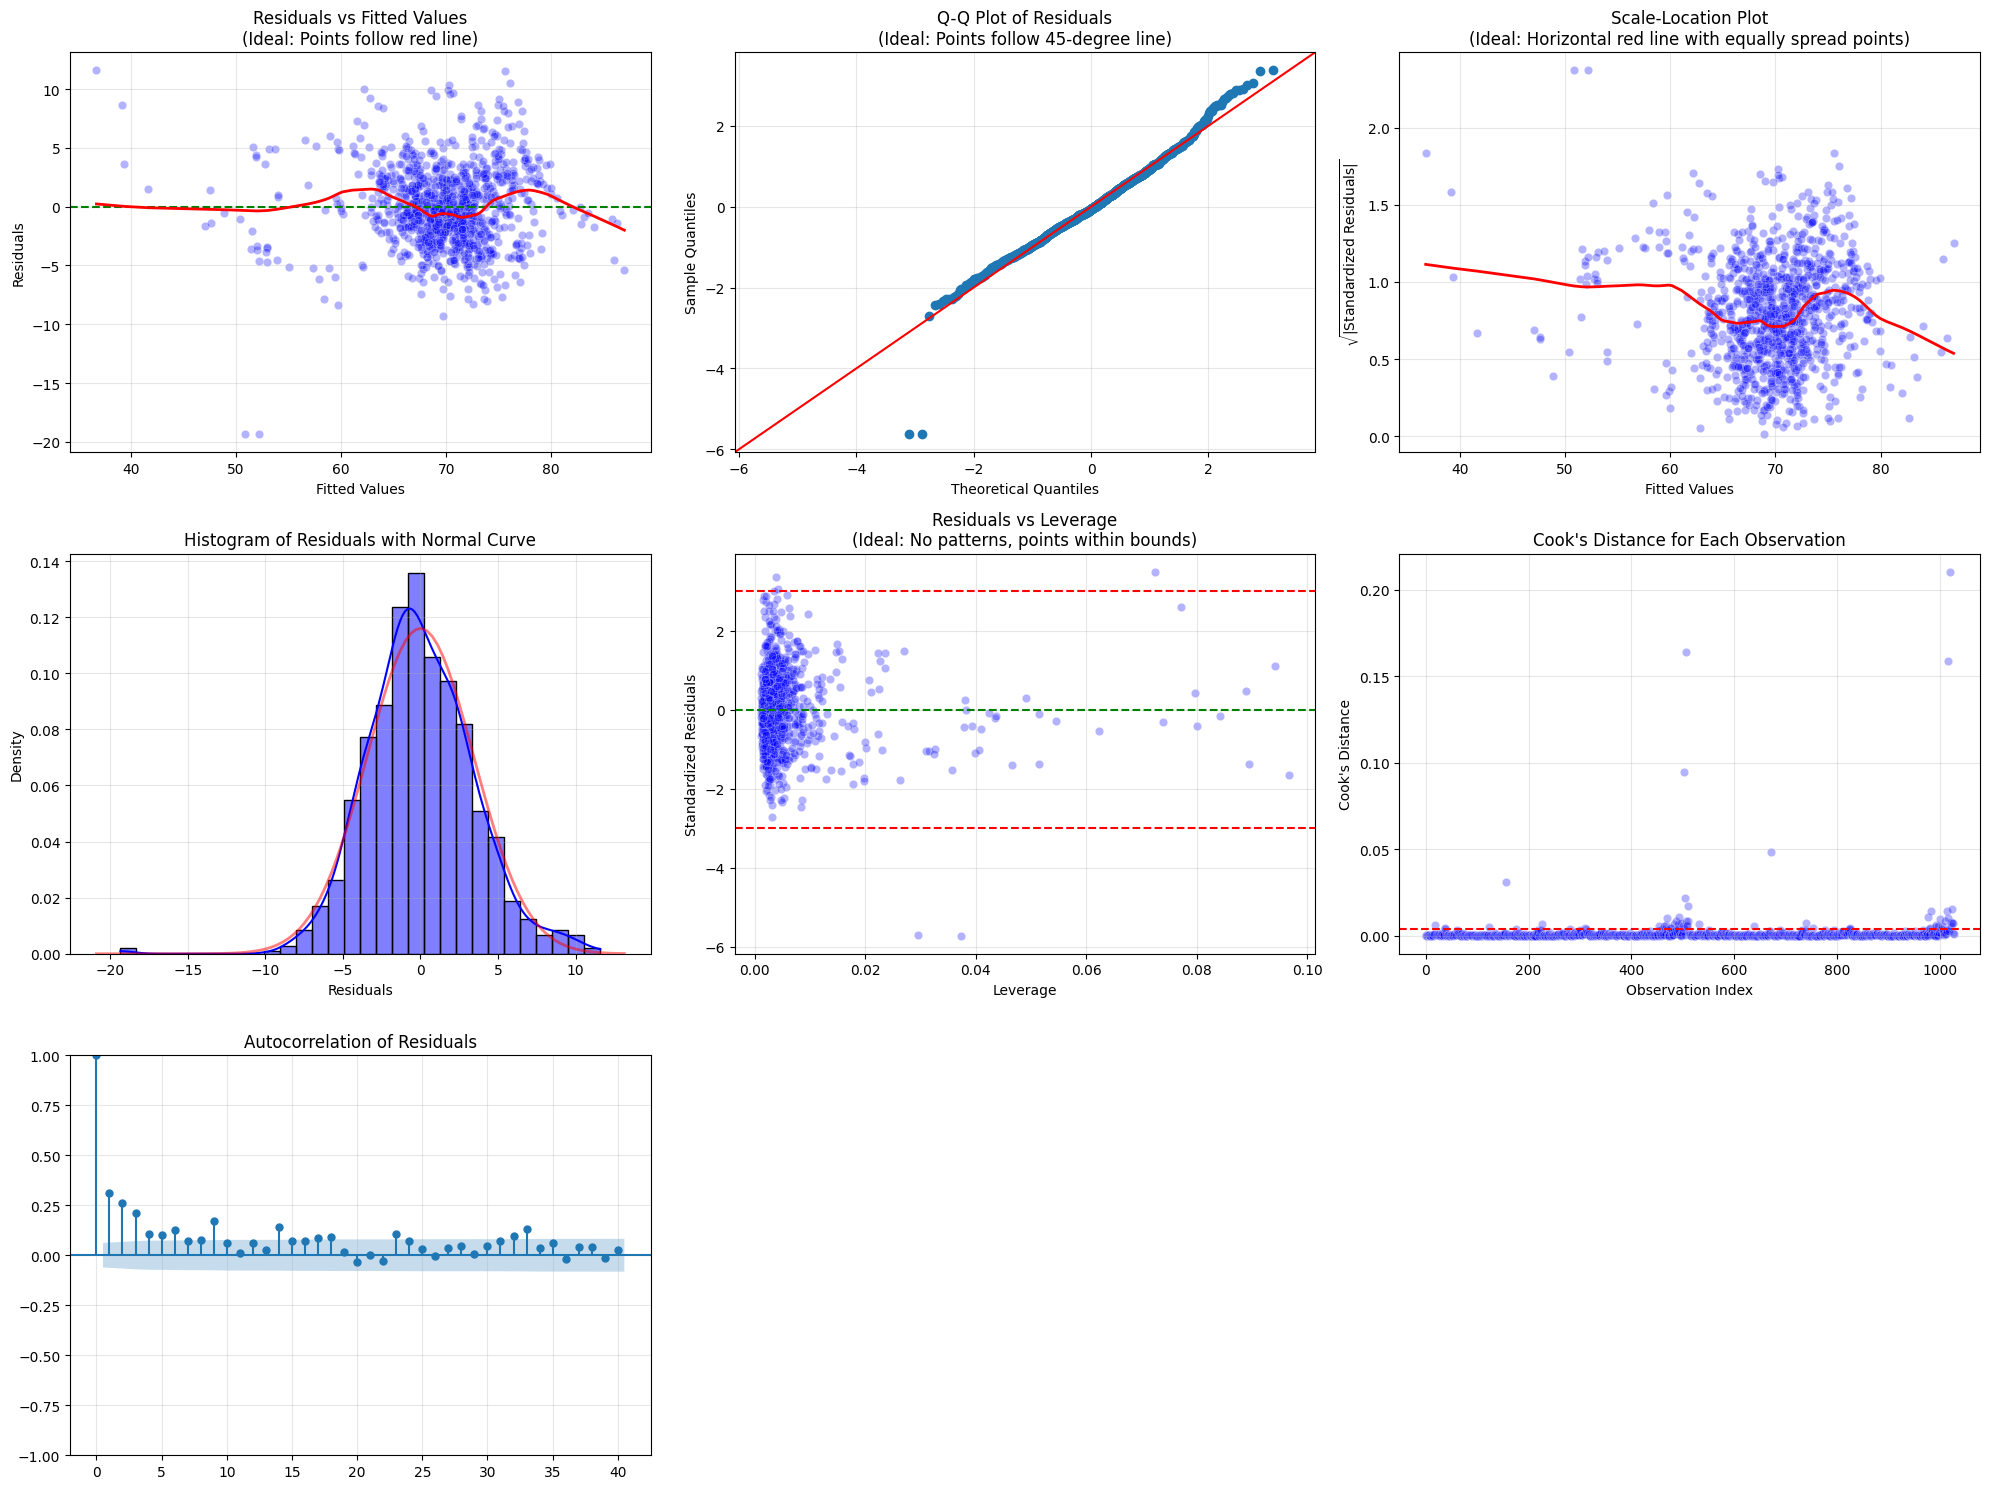

In [19]:
visualize_classical_assumptions(model)

# Preprocessing (Transformasi + Standarisasi)

In [20]:
def preprocess_data(df, variables_to_scale, variables_to_transform):
  preprocess_pipeline = {}
  
  for var in variables_to_transform:
    df[var] = np.log1p(df[var])
    preprocess_pipeline["log_transform"] = variables_to_transform
  
  scaler = StandardScaler()
  df[variables_to_scale] = scaler.fit_transform(df[variables_to_scale])
  preprocess_pipeline["standardization"] = variables_to_scale
  
  return df, preprocess_pipeline

variables_to_transform = [
  'persentase_penduduk_miskin',
  'indeks_kemahalan_konstruksi',
  'produk_domestik_regional_bruto',
  'prevalensi_ketidakcukupan_konsumsi_pangan'
]

scaler = StandardScaler()
variables_to_scale = train_df.columns[2:].tolist()
variables_to_scale.remove(TARGET_COLUMN)

train_df_preprocessed, preprocess_pipeline = preprocess_data(train_df.copy(), variables_to_scale, variables_to_transform)

with open("JSON/preprocess_pipeline.json", "w") as f:
    f.write(json.dumps(preprocess_pipeline, indent=2))

# EDA (Setelah Transformasi)

## Distribusi Tiap Variabel

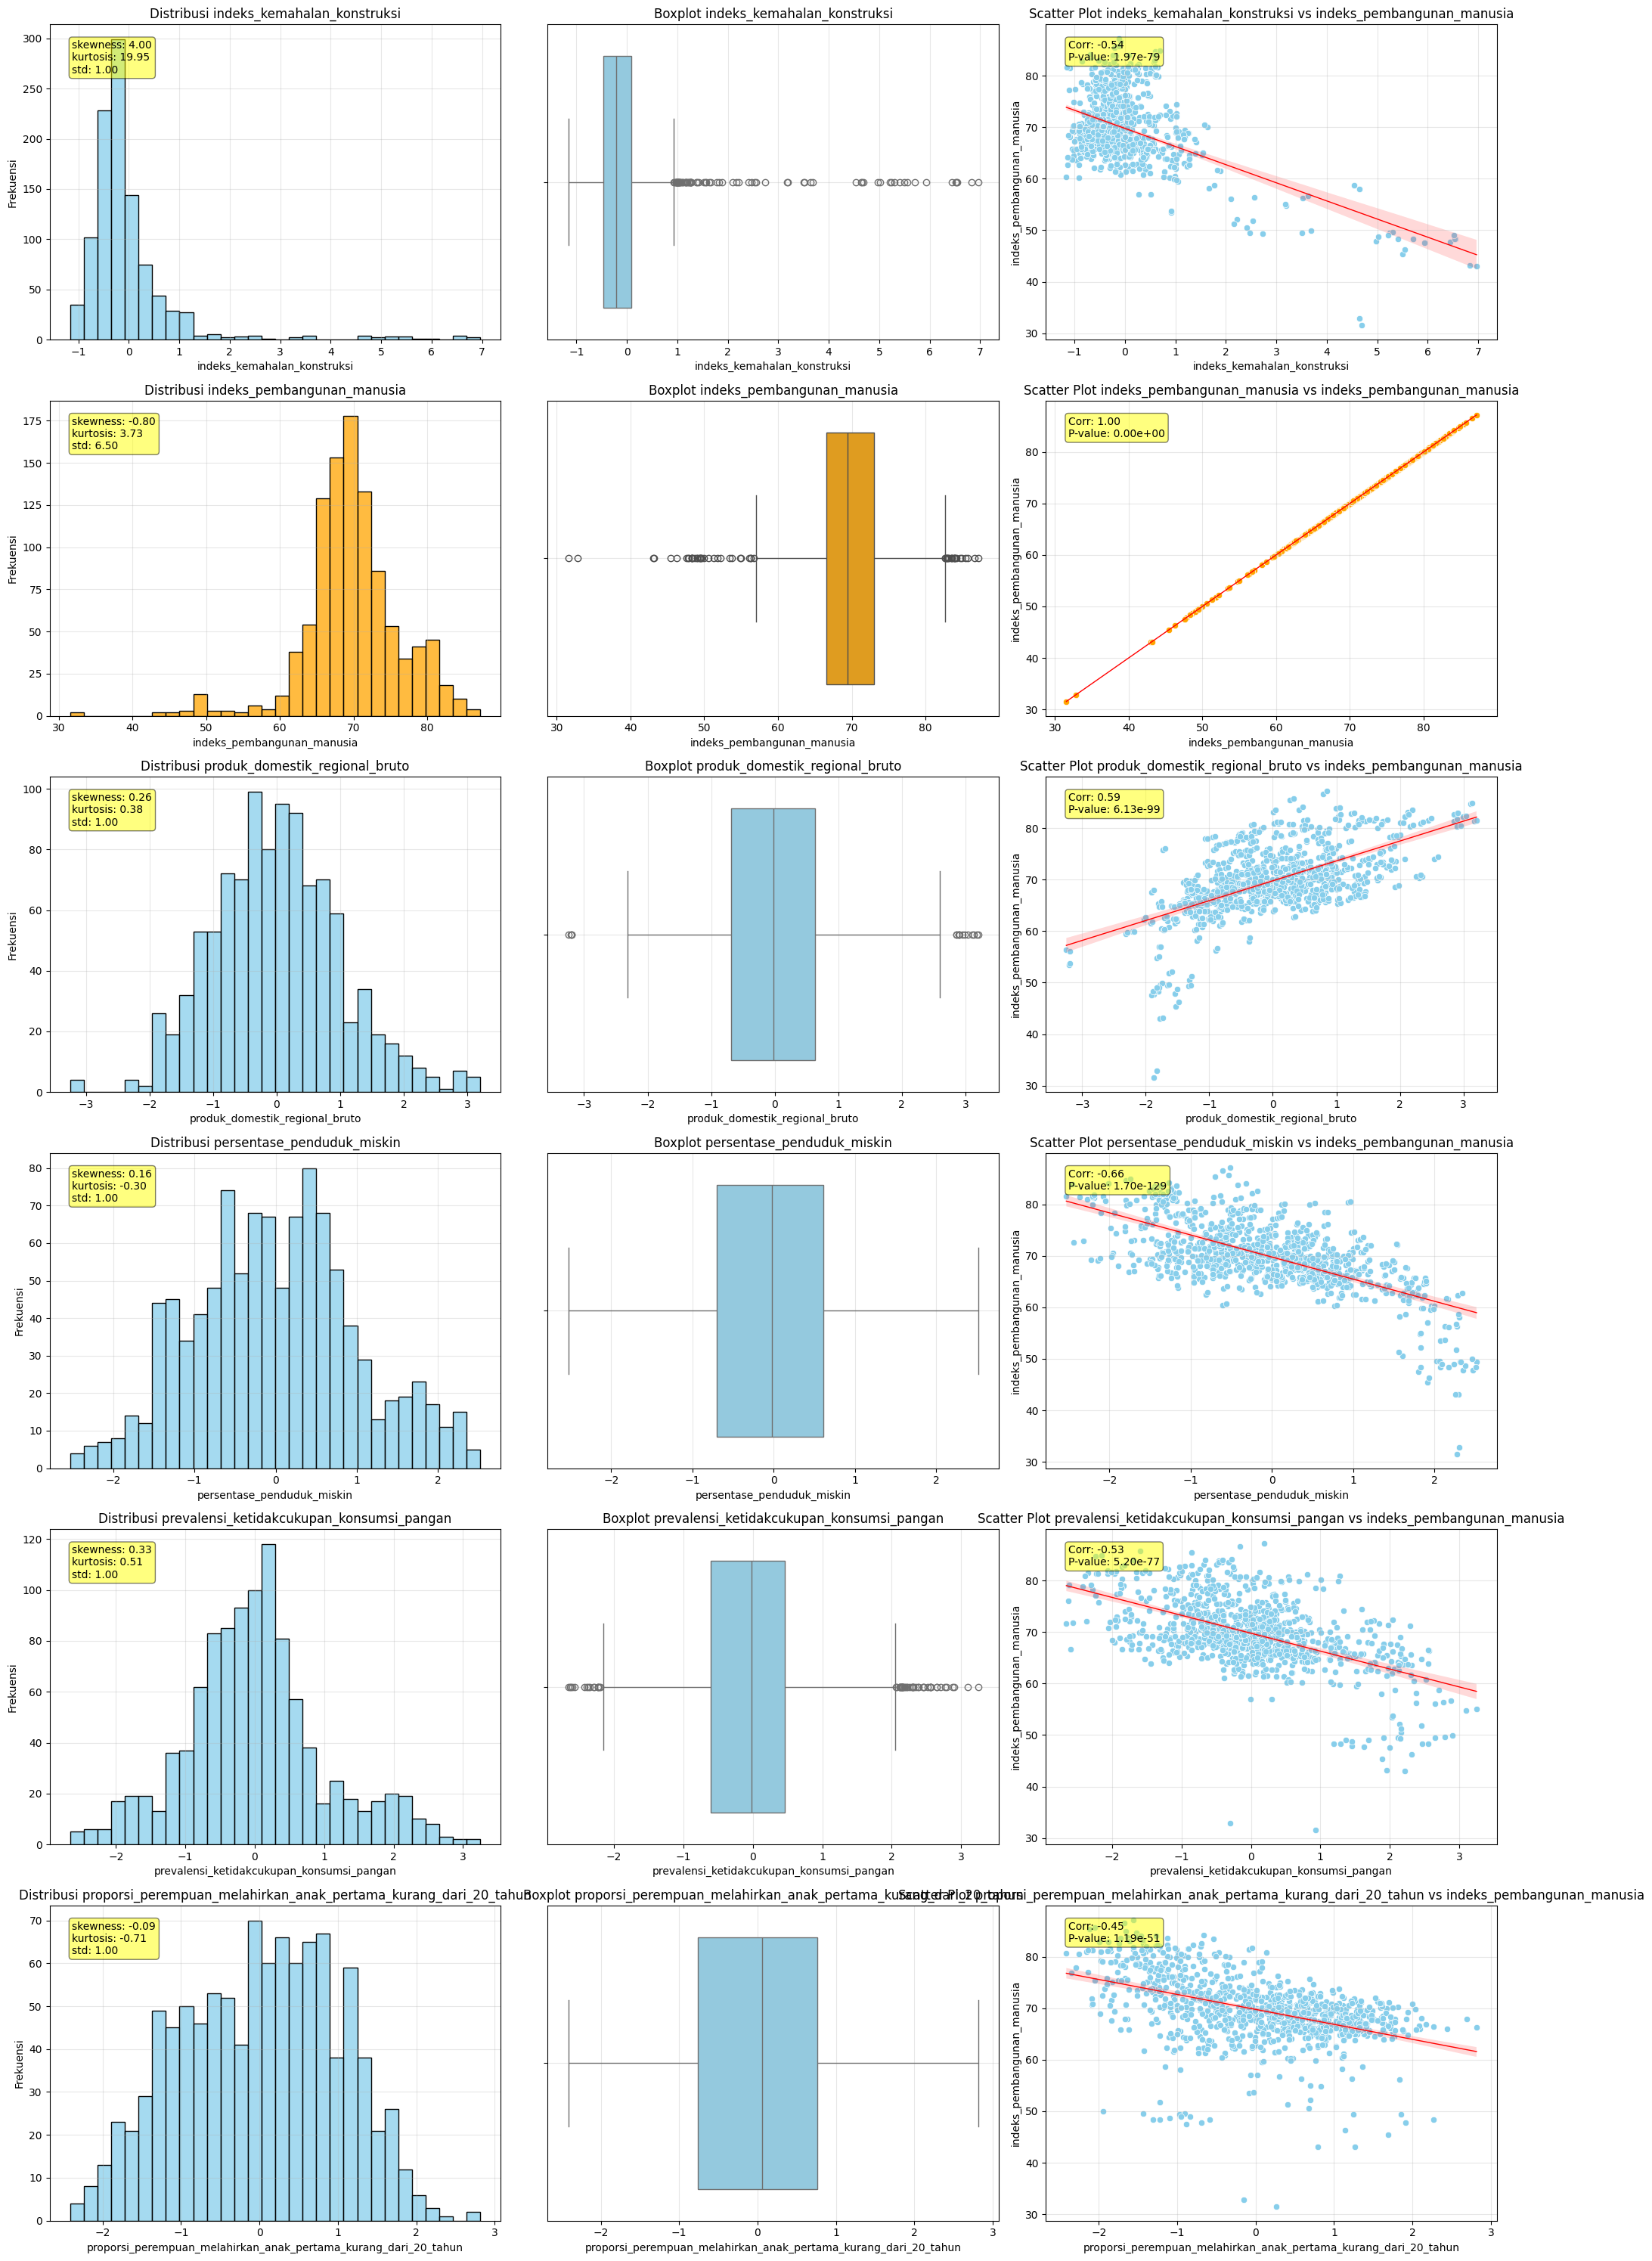

In [21]:
visualize_distribution(train_df_preprocessed, target_column=TARGET_COLUMN)

## Variance Influence Factor (VIF)

Membandingkan VIF sebelum dengan setelah preprocessing

In [22]:
variables = train_df_preprocessed.columns[2:].tolist()
variables.remove(TARGET_COLUMN)

X_preprocessed = train_df_preprocessed[variables]

# Add constant untuk regression
X_const_preprocessed = add_constant(X_preprocessed)

vif_data = pd.DataFrame()
vif_data["Variable"] = variables
vif_data["VIF_preprocessed"] = [variance_inflation_factor(X_const_preprocessed.values, i+1) for i in range(len(variables))]

vif_data

,Variable,VIF_preprocessed
0,indeks_kemahalan_konstruksi,1.342200
1,produk_domestik_regional_bruto,1.423054
2,persentase_penduduk_miskin,1.556938
3,prevalensi_ketidakcukupan_konsumsi_pangan,1.619139
4,proporsi_perempuan_melahirkan_anak_pertama_kur...,1.062948


# Linear Regression (OLS) Post-Transform

## Pemodelan

In [23]:
X = train_df_preprocessed.drop(columns=["kabupaten", "tahun", TARGET_COLUMN])
y = train_df_preprocessed[TARGET_COLUMN]
X = sm.add_constant(X)

model_preprocessed = sm.OLS(y, X).fit(cov_type='HC3')

In [24]:
print(model_preprocessed.summary())

                                OLS Regression Results                                
Dep. Variable:     indeks_pembangunan_manusia   R-squared:                       0.723
Model:                                    OLS   Adj. R-squared:                  0.721
Method:                         Least Squares   F-statistic:                     403.3
Date:                        Sat, 06 Dec 2025   Prob (F-statistic):          7.60e-239
Time:                                18:44:58   Log-Likelihood:                -2724.0
No. Observations:                        1028   AIC:                             5460.
Df Residuals:                            1022   BIC:                             5490.
Df Model:                                   5                                         
Covariance Type:                          HC3                                         
                                                                      coef    std err          z      P>|z|      [0.025      0.975

## Uji Asumsi Klasik

In [25]:
reset_result = linear_reset(model_preprocessed, power=2, use_f=True)
bp_test = het_breuschpagan(model_preprocessed.resid, model_preprocessed.model.exog)

print(reset_result)
print(bp_test)

<F test: F=1.632658490771871, p=0.20162617585202017, df_denom=1.02e+03, df_num=1>
(np.float64(62.983639624263496), np.float64(2.933958841483992e-12), np.float64(13.340557184115445), np.float64(1.286828677628924e-12))


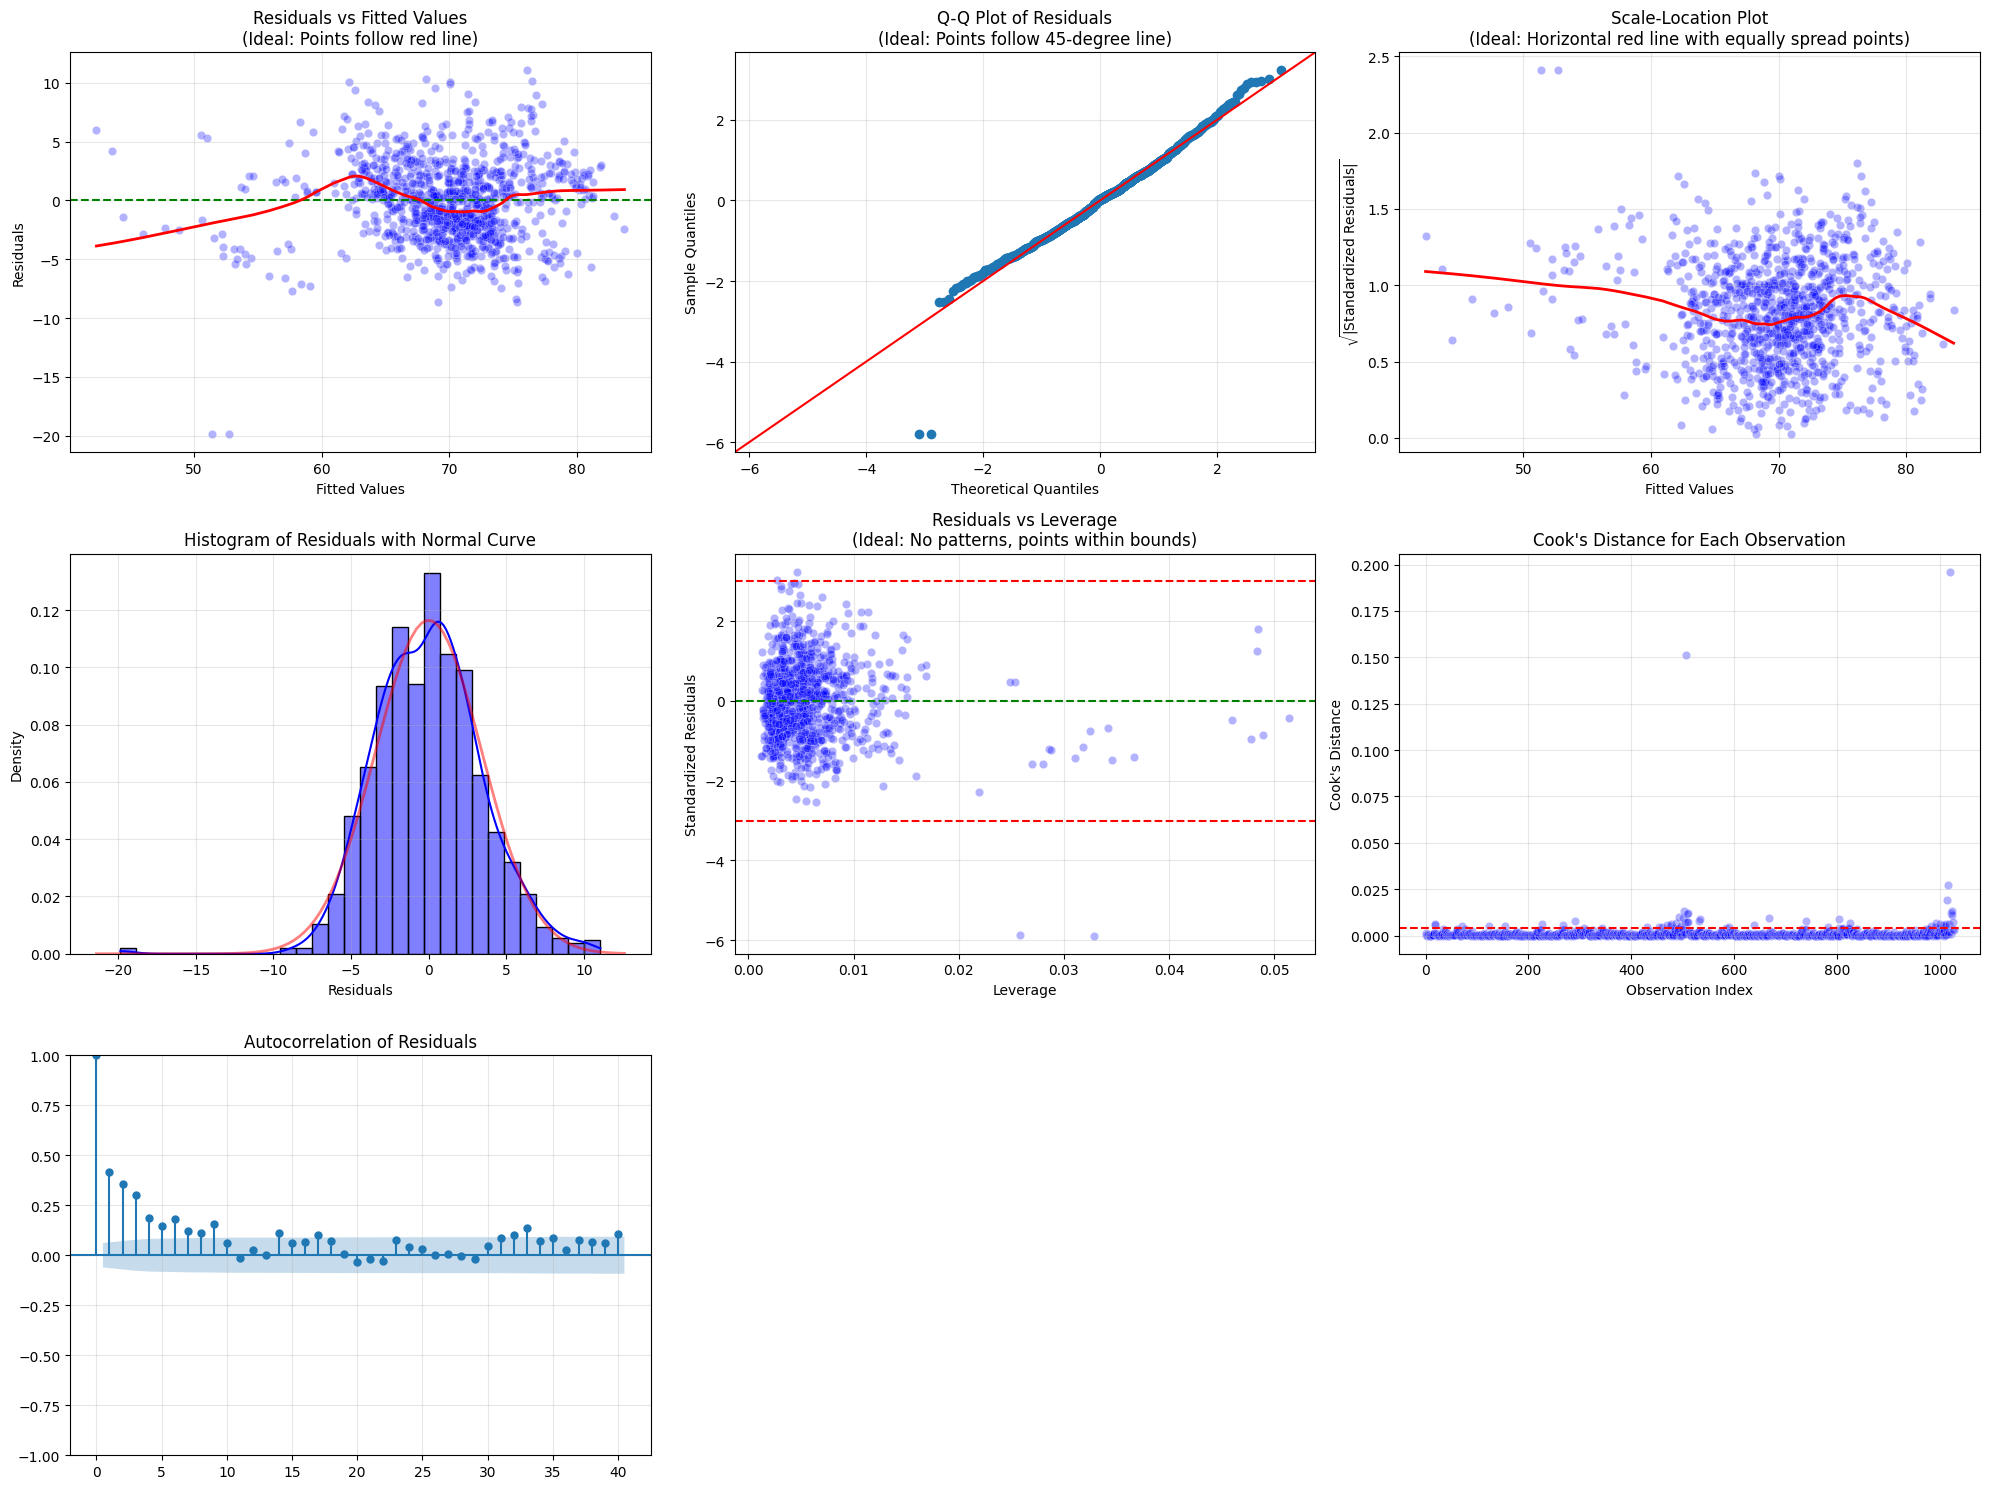

In [26]:
visualize_classical_assumptions(model_preprocessed)

# Linear Regression (OLS) Feature Pruning

## Pemodelan

In [27]:
X = train_df_preprocessed.drop(columns=["kabupaten", "tahun", TARGET_COLUMN, "prevalensi_ketidakcukupan_konsumsi_pangan"])
y = train_df_preprocessed[TARGET_COLUMN]
X = sm.add_constant(X)

model_pruned = sm.OLS(y, X).fit(cov_type='HC3')

In [28]:
print(model_pruned.summary())

                                OLS Regression Results                                
Dep. Variable:     indeks_pembangunan_manusia   R-squared:                       0.722
Model:                                    OLS   Adj. R-squared:                  0.721
Method:                         Least Squares   F-statistic:                     471.6
Date:                        Sat, 06 Dec 2025   Prob (F-statistic):          2.11e-230
Time:                                18:45:02   Log-Likelihood:                -2725.6
No. Observations:                        1028   AIC:                             5461.
Df Residuals:                            1023   BIC:                             5486.
Df Model:                                   4                                         
Covariance Type:                          HC3                                         
                                                                      coef    std err          z      P>|z|      [0.025      0.975

## Uji Asumsi Klasik

In [29]:
reset_result = linear_reset(model_pruned, power=2, use_f=True)
bp_test = het_breuschpagan(model_pruned.resid, model_pruned.model.exog)

print(reset_result)
print(bp_test)

<F test: F=1.9430072960705076, p=0.16364537362064527, df_denom=1.02e+03, df_num=1>
(np.float64(60.24355250136709), np.float64(2.5783576858931486e-12), np.float64(15.9206260955925), np.float64(1.1909224827133766e-12))


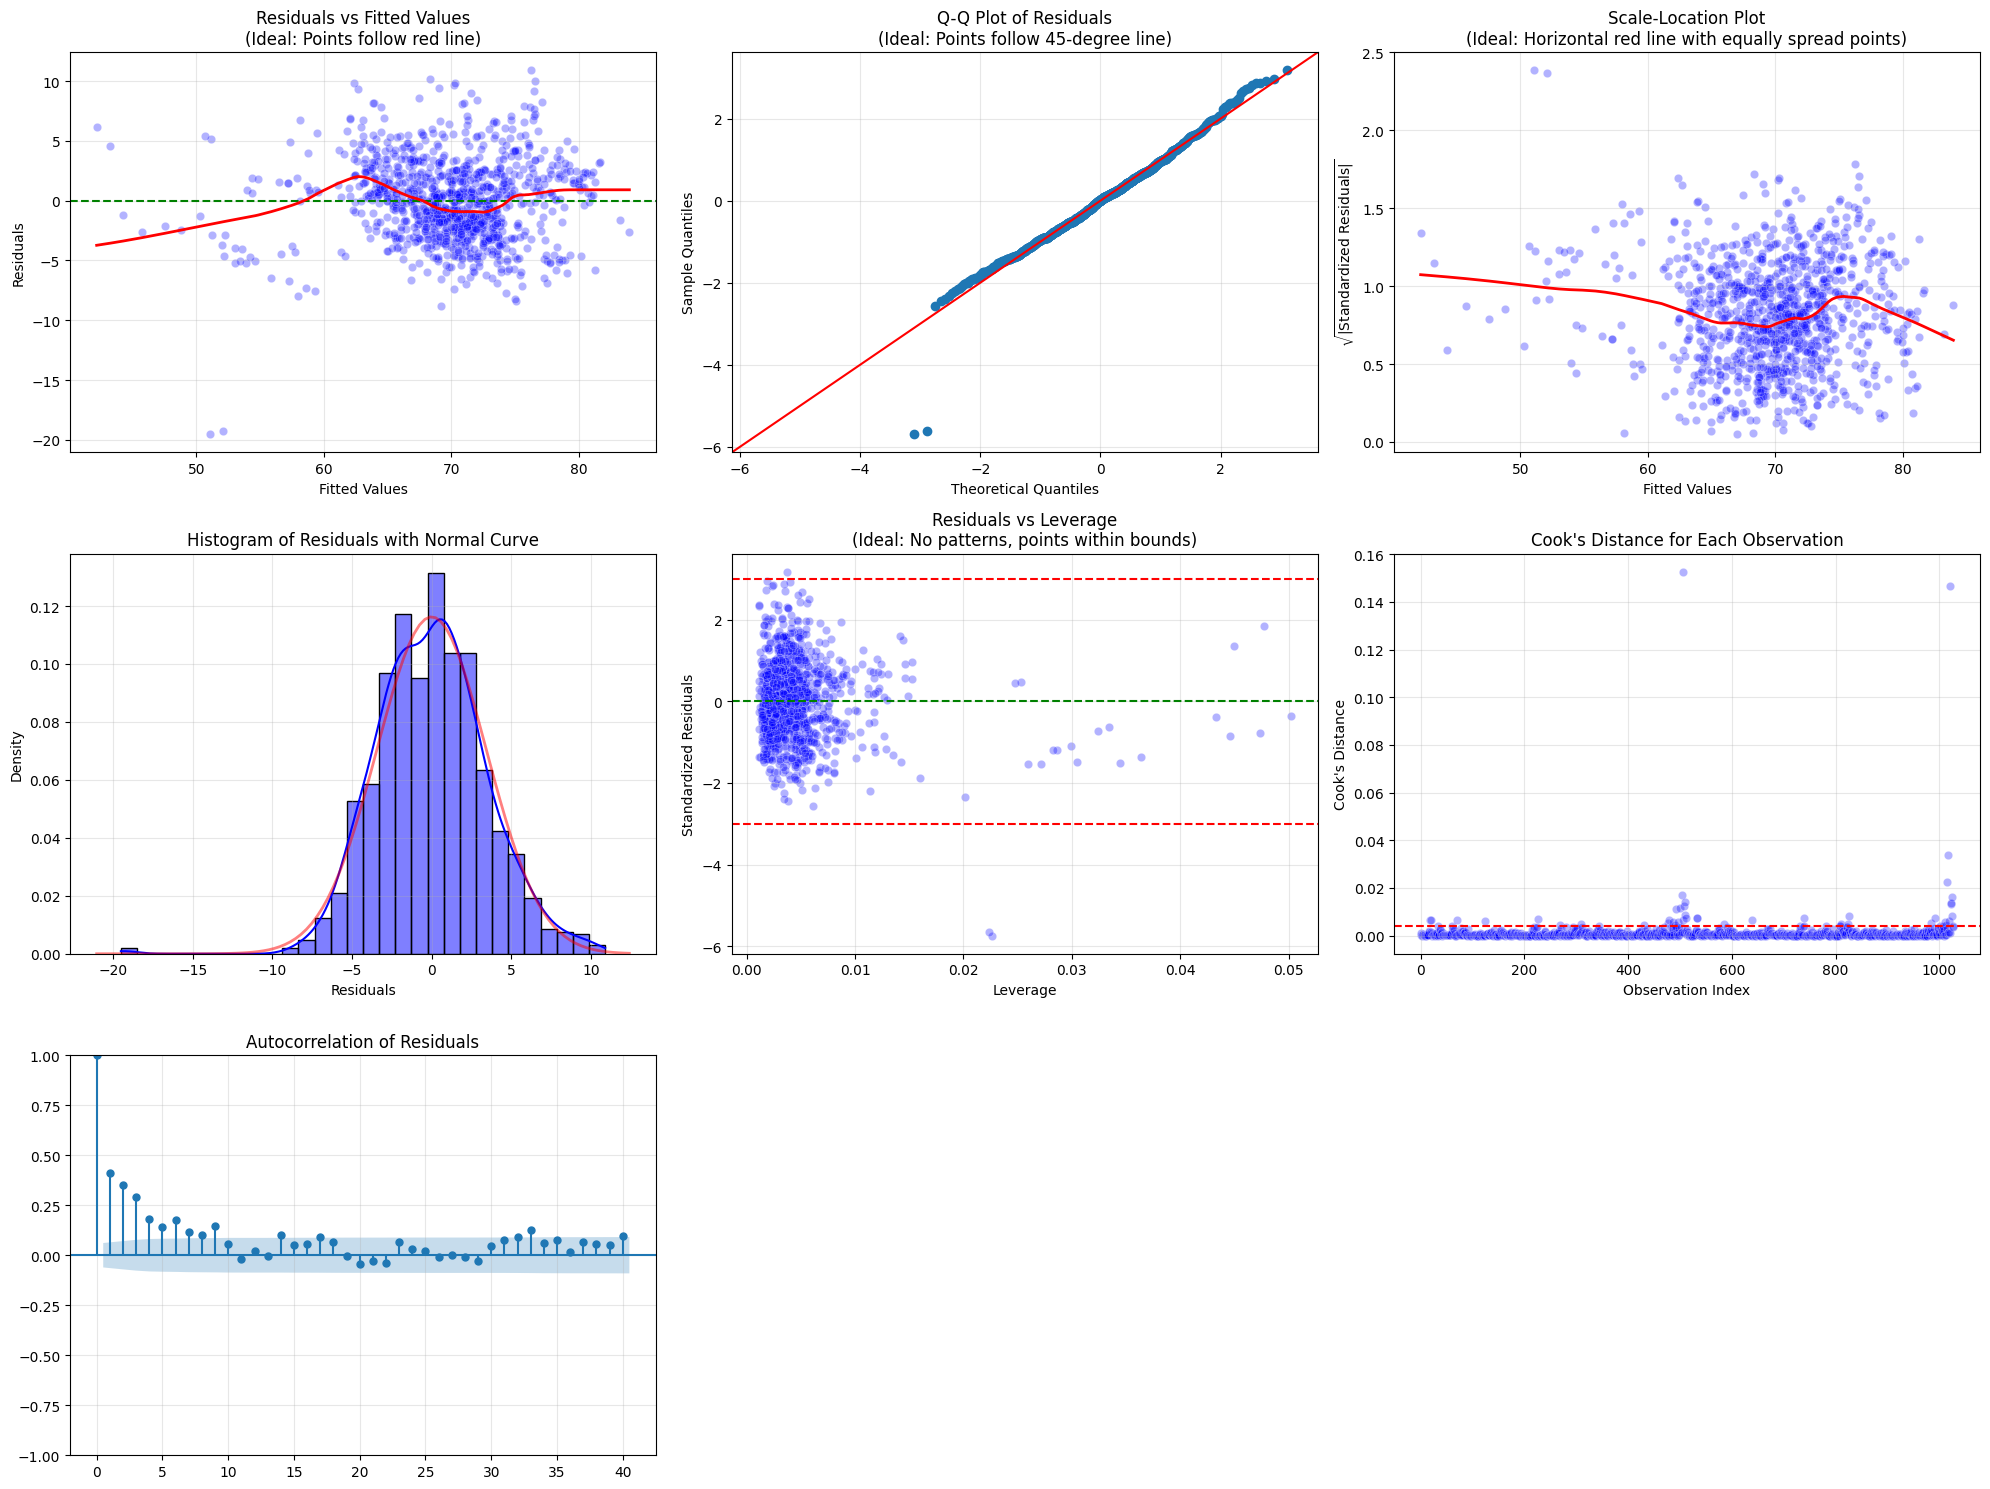

In [30]:
visualize_classical_assumptions(model_pruned)

# Inference (Simulasi)

In [31]:
def preprocess_new_data(df, preprocess_pipeline):
  variables_to_transform = preprocess_pipeline["log_transform"]
  
  for var in variables_to_transform:
    df[var] = np.log1p(df[var])
  
  variables_to_scale = preprocess_pipeline["standardization"]
  
  scaler = StandardScaler()
  df[variables_to_scale] = scaler.fit_transform(df[variables_to_scale])
  
  return df

with open("JSON/preprocess_pipeline.json", 'r') as f:
  preprocess_pipeline = json.load(f)

test_df_preprocessed = preprocess_new_data(test_df.copy(), preprocess_pipeline)

X_test = test_df_preprocessed.drop(columns=["kabupaten", "tahun", TARGET_COLUMN, "prevalensi_ketidakcukupan_konsumsi_pangan"])
X_test = sm.add_constant(X_test)

y_pred = model_pruned.predict(X_test)
y_actual = test_df[TARGET_COLUMN].values
errors = y_actual - y_pred
absolute_errors = np.abs(errors)
squared_errors = errors ** 2

metrics = {
'MAE': np.mean(absolute_errors),
'MSE': np.mean(squared_errors),
'RMSE': np.sqrt(np.mean(squared_errors)),
'R²': r2_score(y_actual, y_pred),
'Mean Error': np.mean(errors),
'Std Error': np.std(errors)
}

for metric, value in metrics.items():
  print(f"{metric}: {value}")

MAE: 2.7305679833972847
MSE: 12.344323444114188
RMSE: 3.5134489385949794
R²: 0.700399699708308
Mean Error: 0.810632295719835
Std Error: 3.4186545197270486


Full Dataset Inference

In [32]:
pred_df = test_df.copy()[["kabupaten", "tahun"]]
pred_df[f'prediksi_{TARGET_COLUMN}'] = y_pred

pred_df

,kabupaten,tahun,prediksi_indeks_pembangunan_manusia
1028,Simeulue,2022,65.628326
1029,Aceh Singkil,2022,63.933918
1030,Aceh Selatan,2022,70.096039
1031,Aceh Tenggara,2022,68.991440
1032,Aceh Timur,2022,69.053969
...,...,...,...
1537,Tolikara,2022,54.759635
1538,Mamberamo Tengah,2022,51.940100
1539,Yalimo,2022,53.337310
1540,Yahukimo,2022,54.407293


## EXPORT DATA PRED 2022

In [33]:
pred_df.to_csv("Processed Data/prediksi_2022.csv", index=False)

In [34]:
pip install nbconvert


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
